In [ ]:
import os
from dotenv import load_dotenv

os.environ["USER_AGENT"] = "AnalystChain/1.0 (Python Analysis Tool)"
load_dotenv("../../config/.env")

True

In [4]:
import bs4
from typing_extensions import TypedDict, List
from langchain import hub
from langchain.chat_models import init_chat_model
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langgraph.graph import StateGraph, START
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

llm = init_chat_model("deepseek-chat", model_provider="deepseek")

embeddings = HuggingFaceEmbeddings(model_name="Qwen/Qwen3-Embedding-0.6B")
vector_store = InMemoryVectorStore(embeddings)
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    )
)
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)
_ = vector_store.add_documents(documents=all_splits)

prompt = hub.pull("rlm/rag-prompt")

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieve_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieve_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()
response = graph.invoke({"question": "什么是任务拆分？"})

print(response["answer"])

USER_AGENT environment variable not set, consider setting it to identify your requests.


任务拆分是指将一个复杂任务分解成多个较小、更易管理的子任务的过程。根据上下文，它可以由大型语言模型通过简单提示完成，或依赖外部规划器（如LLM+P）进行处理。这种方法有助于理清任务间的逻辑关系和依赖顺序。


In [7]:
for step in graph.stream(
    {"question": "什么是任务拆分？"},
    stream_mode="updates",
):
    print(f"f{step}\n---------------\n")

f{'retrieve': {'context': [Document(id='2be4484f-4507-482c-8e8a-b13758c176b2', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='The AI assistant can parse user input to several tasks: [{"task": task, "id", task_id, "dep": dependency_task_ids, "args": {"text": text, "image": URL, "audio": URL, "video": URL}}]. The "dep" field denotes the id of the previous task which generates a new resource that the current task relies on. A special tag "-task_id" refers to the generated text image, audio and video in the dependency task with id as task_id. The task MUST be selected from the following options: {{ Available Task List }}. There is a logical relationship between tasks, please note their order. If the user input can\'t be parsed, you need to reply empty JSON. Here are several cases for your reference: {{ Demonstrations }}. The chat history is recorded as {{ Chat History }}. From this chat history, you can find the path of the user-mentioned resourc

In [11]:
for message, _ in graph.stream(
    {"question": "什么是任务拆分？"},
    stream_mode="messages",
):
    print(message.content, end="|")

|任务|拆分|是指|将|一项|复杂|任务|分解|成|多个|较小|、|更|易|管理的|子|任务|的过程|。|根据|上下文|，|它可以|由|大型|语言|模型|通过|简单|提示|完成|，|或|依赖|外部|规划|器|（|如|LL|M|+P|方法|）|进行处理|。|这种方法|有助于|理|清|任务|间的|逻辑|关系和|依赖|顺序|。||

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


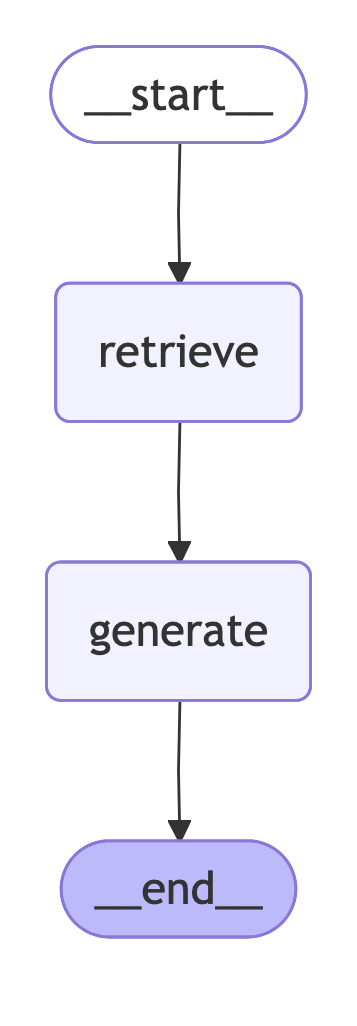

In [10]:
import nest_asyncio
from IPython.display import Image, display
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

# 允许嵌套事件循环
nest_asyncio.apply()
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


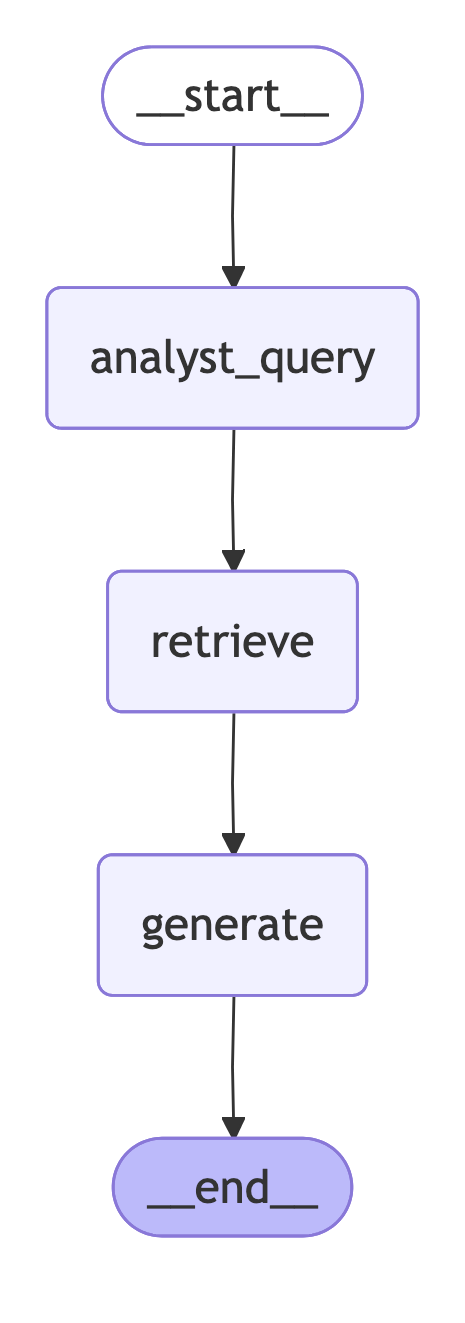

In [ ]:
from typing import Literal
from typing_extensions import Annotated

class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

def analyst_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"]
    )
    return {"context": retrieved_docs}

thrid = len(all_splits) // 3
for i, document in enumerate(all_splits):
    if i < thrid:
        document.metadata["section"] = "beginning"
    if i < 2 * thrid:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

graph_builder = StateGraph(State).add_sequence([analyst_query, retrieve, generate])
graph_builder.add_edge(START, "analyst_query")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [16]:
for step in graph.stream(
    {"question": "帖子结尾关于任务分解说了什么？"},
    stream_mode="updates",
):
    print(f"{step}\n----------------\n")

{'analyst_query': {'query': {'query': '任务分解', 'section': 'end'}}}
----------------

{'retrieve': {'context': [Document(id='7daffc73-e06a-4b9e-afbd-0653c9367494', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'end'}, page_content='},\n  {\n    "role": "user",\n    "content": "{{There are 10 levels in total. The main character is a plumber named Mario, who can walk and jump. It is a classical platform game just like Super Mario. The main character moves from left to right, trying to get to the destination, where there are many obstacles and attacks from enemies in the process.}}\\n\\nIs anything else unclear? If yes, only answer in the form:\\n{remaining unclear areas} remaining questions.\\n{Next question}\\nIf everything is sufficiently clear, only answer \\"Nothing more to clarify.\\"."\n  },\n  {\n    "role": "assistant",\n    "content": "Remaining unclear areas: 2 remaining questions.\\nCan you provide more information about how the MVC compo